# Computer Vision Masterclass: GANs

- Adapted from: https://www.tensorflow.org/beta/tutorials/generative/dcgan

## Importing the libraries

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.7.0'

## Loading and pre-processing the dataset

In [45]:
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

In [46]:
X_train.shape

(60000, 28, 28)

6


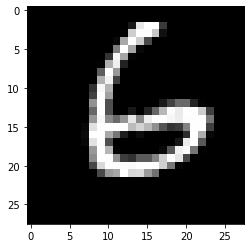

In [47]:
i = np.random.randint(0, 60000)
print(y_train[i])
plt.imshow(X_train[i], cmap='gray');

In [48]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [49]:
X_train.shape,X_train[0].min(), X_train[0].max()

((60000, 28, 28, 1), 0.0, 255.0)

In [50]:
X_train = (X_train - 127.5) / 127.5

In [51]:
X_train[0].min(), X_train[0].max()

(-1.0, 1.0)

In [52]:
buffer_size = 60000
batch_size = 256

In [53]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

## Building the generator

- Batch normalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
- Leaky Relu: https://keras.io/api/layers/activation_layers/leaky_relu/
- Activation functions: https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e
- Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

In [54]:
def build_generator():
    """
    Create generator model
    """
    network = tf.keras.Sequential()
    
    network.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())
    
    # 7x7x128
    network.add(layers.Reshape((7,7,256)))
    network.add(layers.Conv2DTranspose(128,(5,5),padding="same",use_bias=False))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())
    
    # 14x14x64
    network.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding="same",use_bias=False))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())
    
    # 28x28x1
    network.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding="same",use_bias=False,activation="tanh"))
    
    network.summary()
    
    return network

In [55]:
generator = build_generator()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)       

In [56]:
noise = tf.random.normal([1, 100])

In [57]:
generated_image = generator(noise, training = False)

In [58]:
generated_image.shape

TensorShape([1, 28, 28, 1])

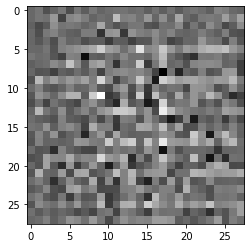

In [59]:
plt.imshow(generated_image[0,:,:,0], cmap='gray');

## Building the discriminator

- Dropout: http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf

In [60]:
def build_discriminator():
    """
    Create discriminator model
    """
    network = tf.keras.Sequential()
    
    # 14x14x64
    network.add(layers.Conv2D(64,(5,5),strides=(2,2),padding="same",input_shape=[28,28,1]))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))
    
    # 7x7x128
    network.add(layers.Conv2D(128,(5,5),strides=(2,2),padding="same"))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))
    
    network.add(layers.Flatten())
    network.add(layers.Dense(1))
    
    network.summary()
    
    return network

In [61]:
discriminator = build_discriminator()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

In [62]:
discriminator(generated_image, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00038462]], dtype=float32)>

## Calculating the loss

- Logits: https://deepai.org/machine-learning-glossary-and-terms/logit

In [63]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [64]:
def discriminator_loss(expected_output,fake_output):
    """
    Calculate the loss of discriminator
    """
    real_loss = cross_entropy(tf.ones_like(expected_output),expected_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss+fake_loss
    return total_loss

In [65]:
def generator_loss(fake_output):
    """
    Calculate the loss of generator
    """
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [66]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

## Training the model

In [67]:
epochs = 100
noise_dim = 100
num_images_to_generate = 16

In [68]:
@tf.function
def train_steps(images):
    noise = tf.random.normal([batch_size,noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise,training=True)
        
        expected_output = discriminator(images,training=True)
        fake_output = discriminator(generated_images,training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(expected_output,fake_output)
    
    gradient_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradient_of_discriminator,discriminator.trainable_variables))

In [69]:
test_images = tf.random.normal([num_images_to_generate, noise_dim])

In [70]:
test_images.shape

TensorShape([16, 100])

In [71]:
60000 / 256

234.375

In [72]:
def train(dataset,epochs,test_images):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_steps(image_batch)
        print(f"Epoch: {epoch+1}")
        generated_images = generator(test_images,training=False)
        fig = plt.figure(figsize=(10,10))
        for i in range(generated_images.shape[0]):
            plt.subplot(4,4,i+1)
            plt.imshow(generated_images[i,:,:,0]*127.5+127.5,cmap="gray")
            plt.axis("off")
        plt.show()

Epoch: 1


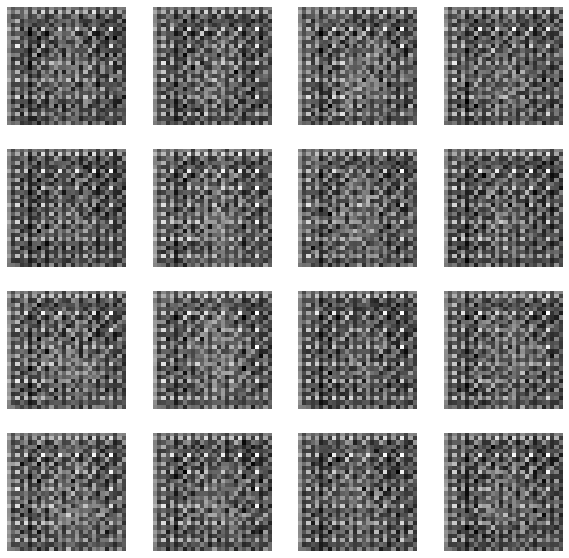

Epoch: 2


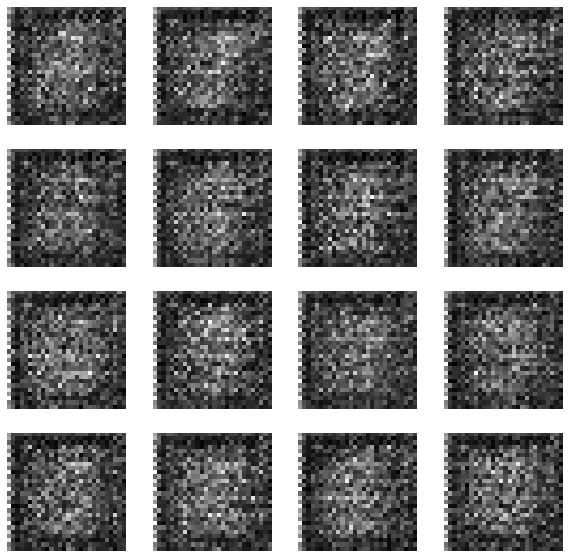

Epoch: 3


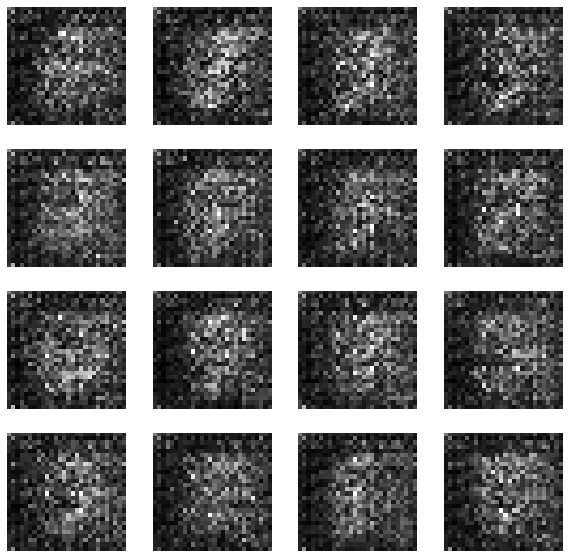

Epoch: 4


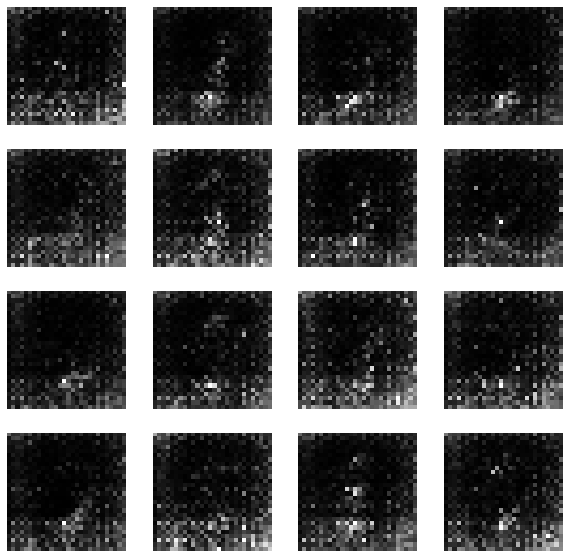

Epoch: 5


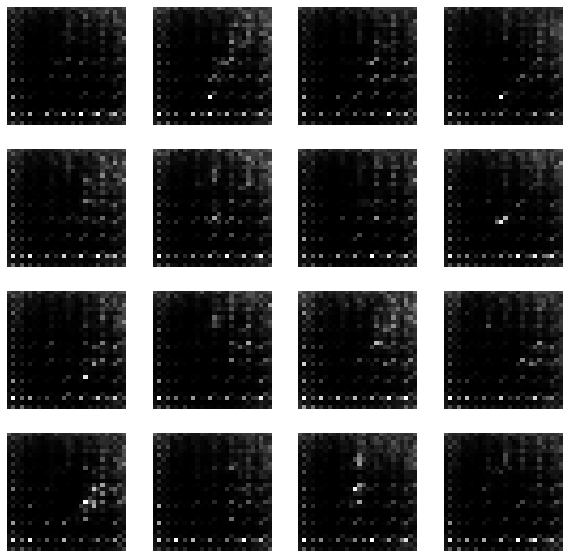

Epoch: 6


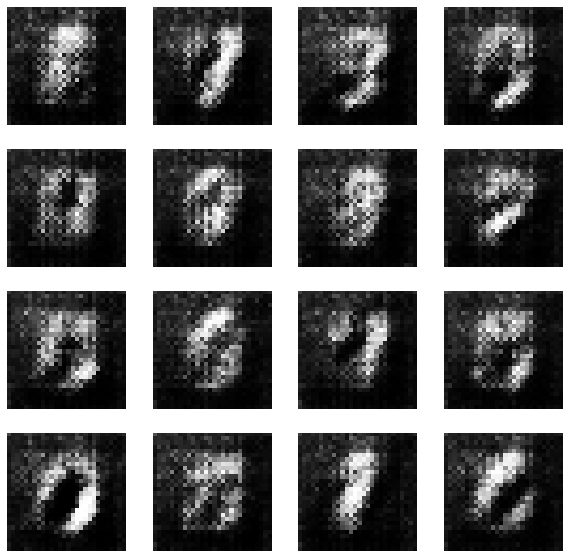

Epoch: 7


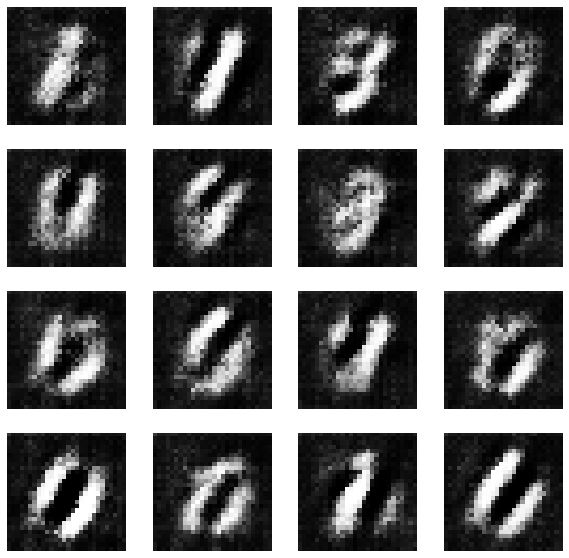

Epoch: 8


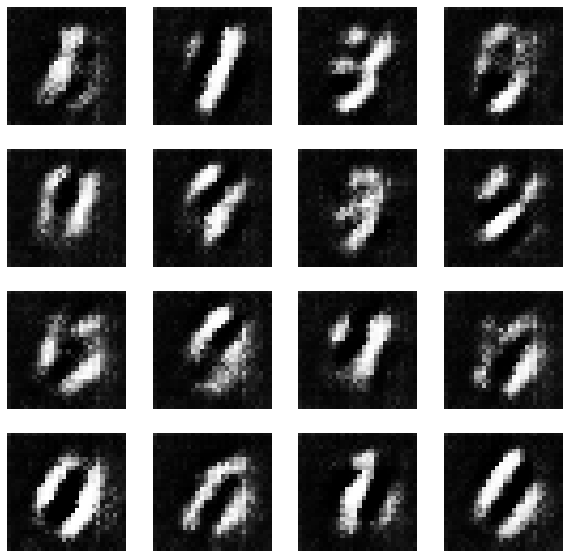

Epoch: 9


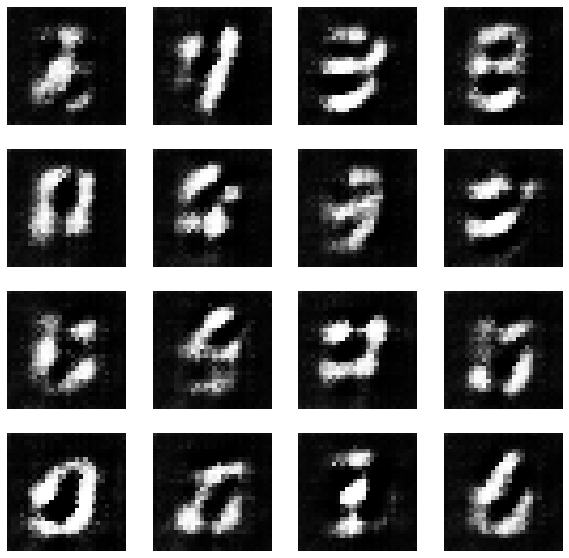

Epoch: 10


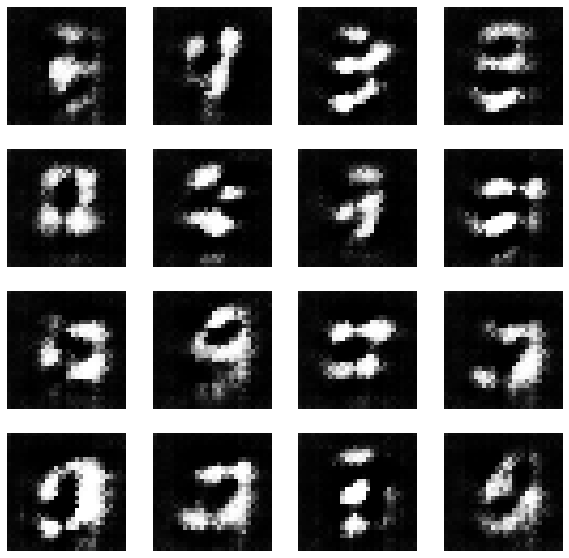

Epoch: 11


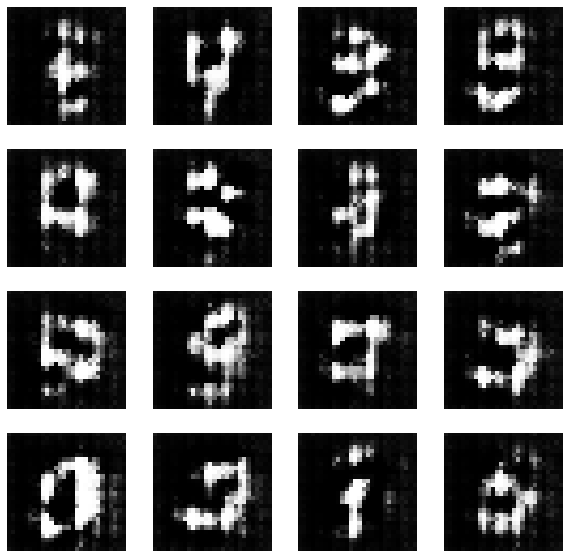

Epoch: 12


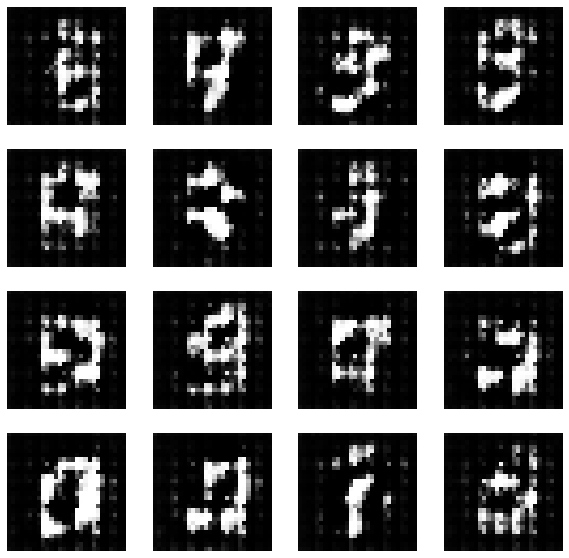

Epoch: 13


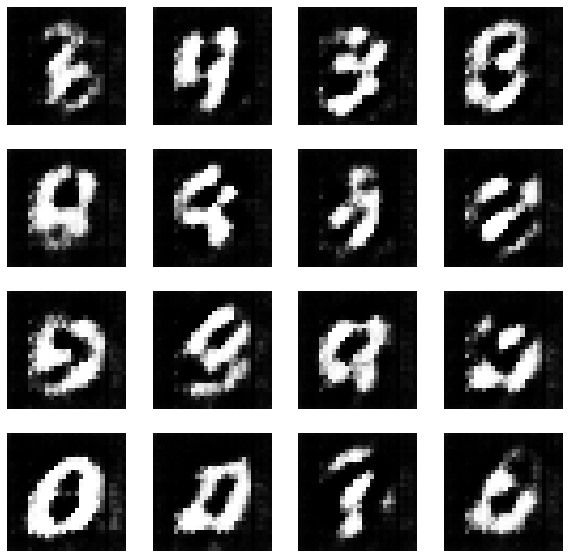

Epoch: 14


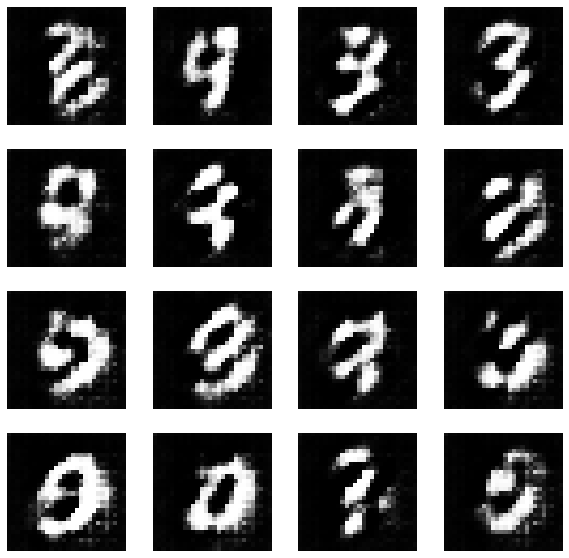

Epoch: 15


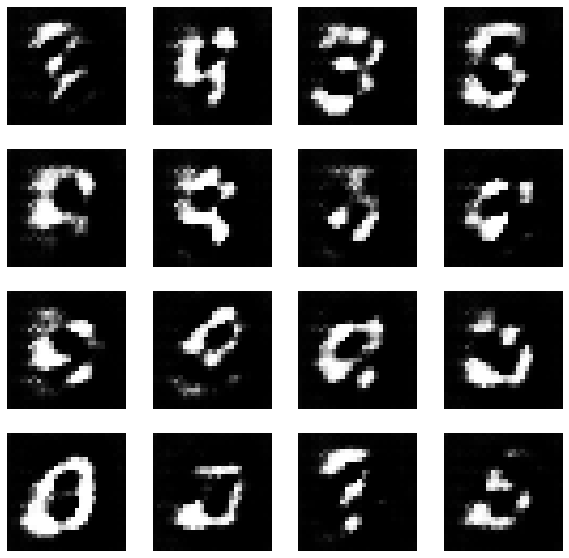

Epoch: 16


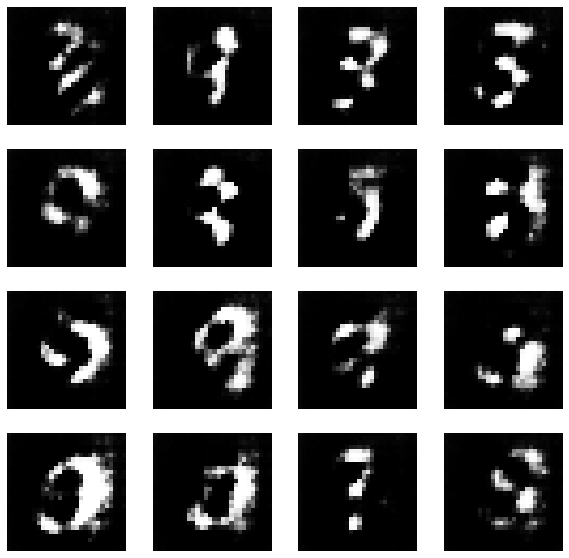

Epoch: 17


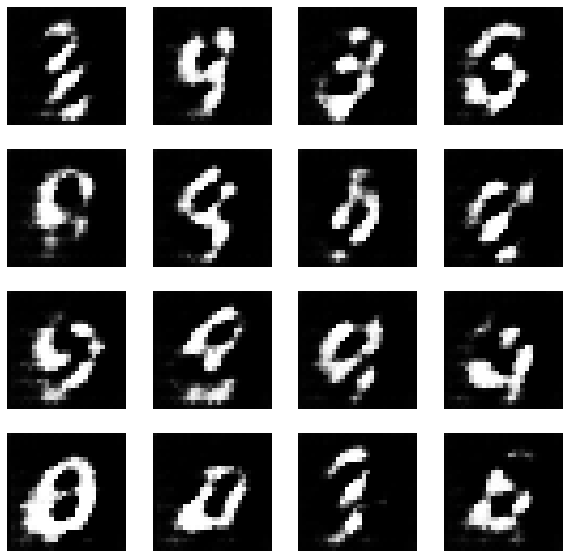

Epoch: 18


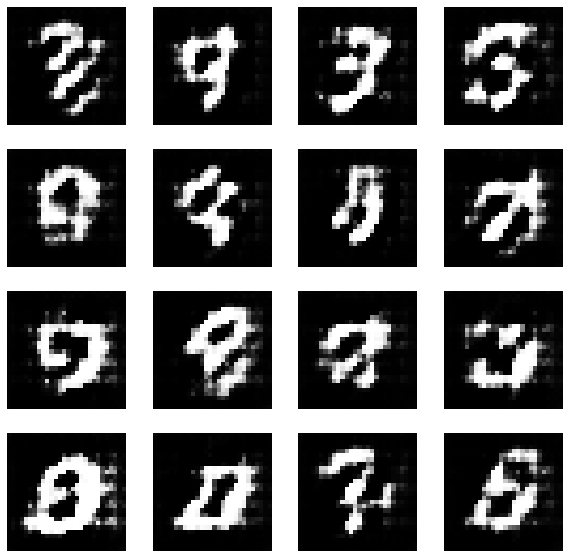

Epoch: 19


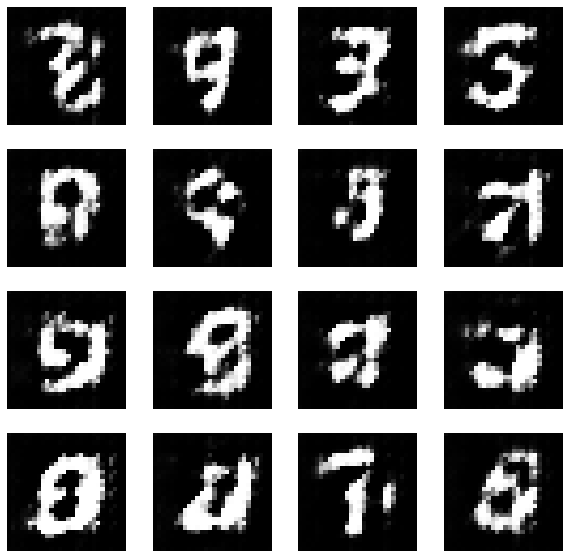

Epoch: 20


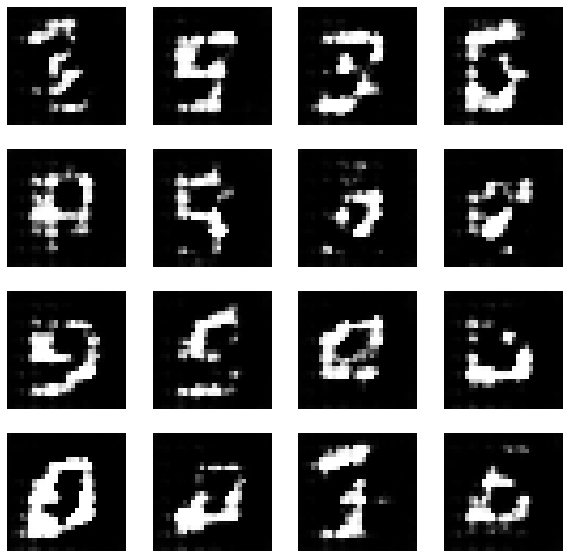

Epoch: 21


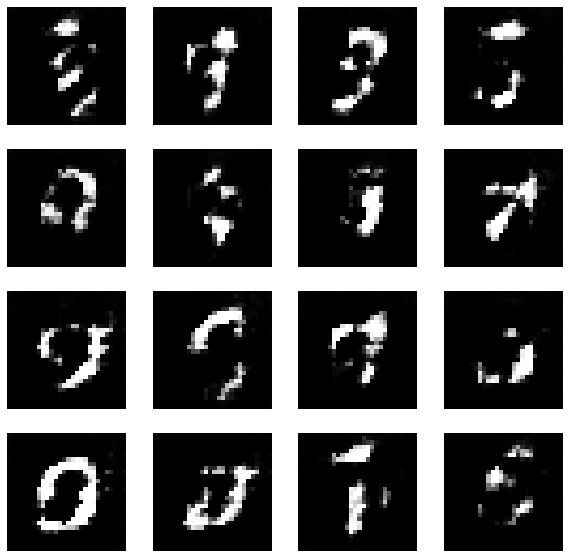

Epoch: 22


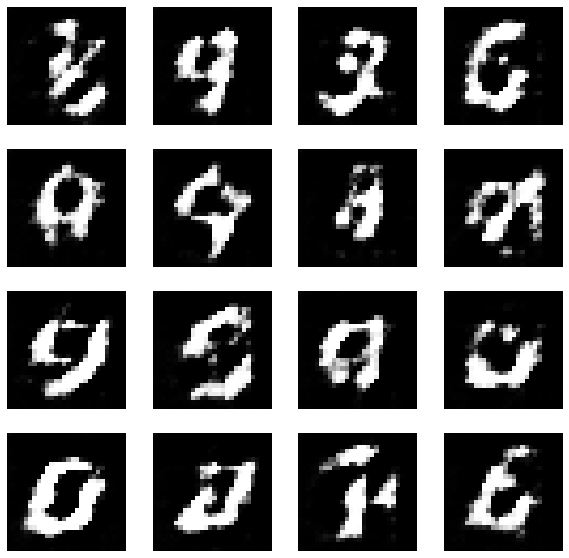

Epoch: 23


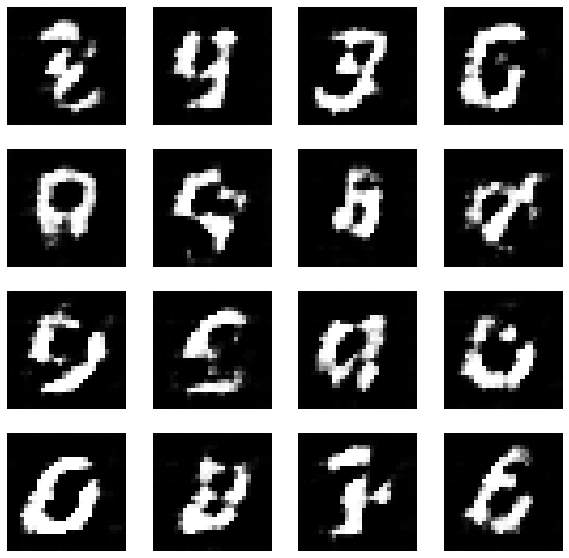

Epoch: 24


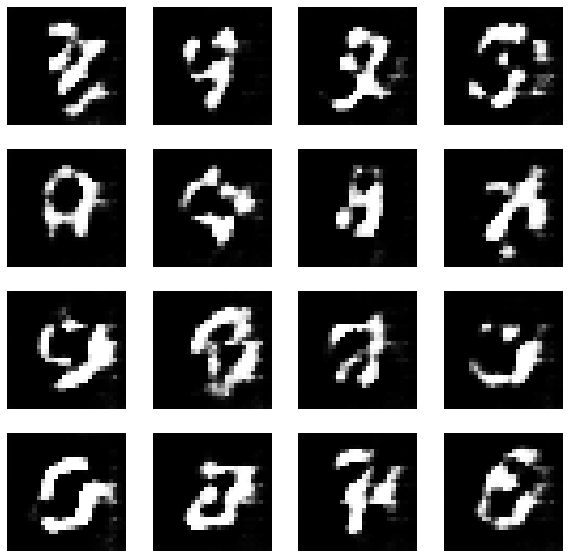

Epoch: 25


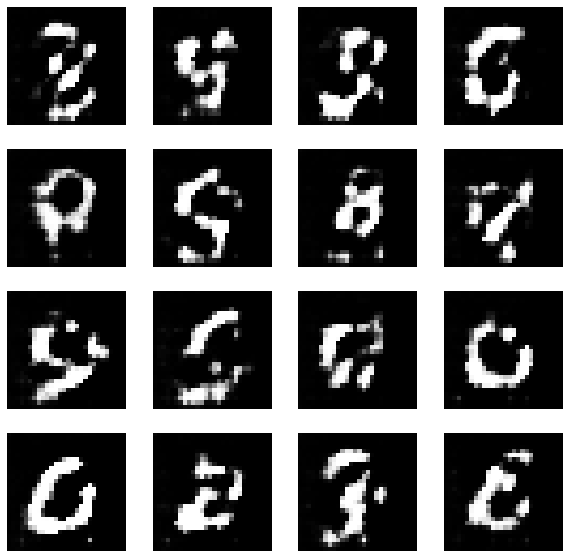

Epoch: 26


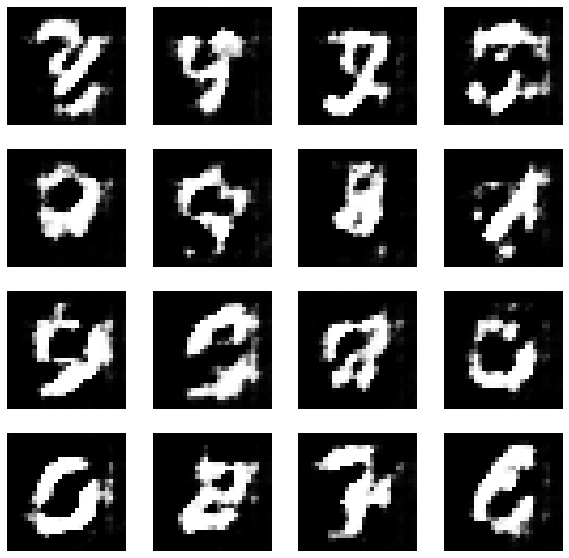

Epoch: 27


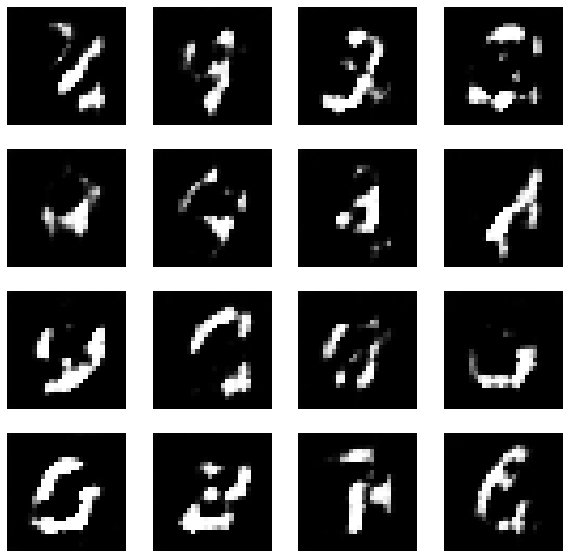

Epoch: 28


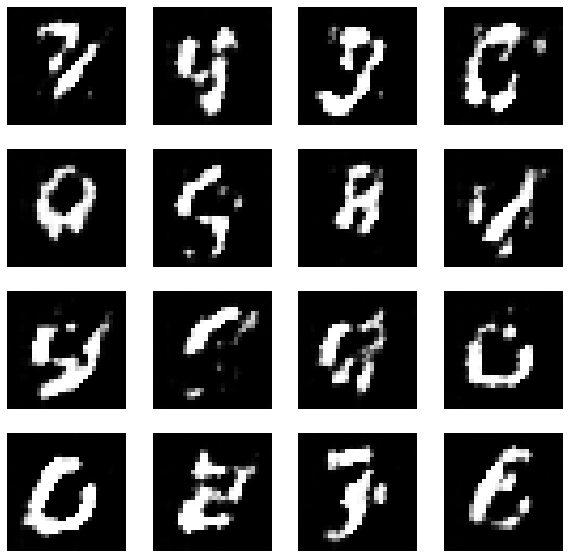

Epoch: 29


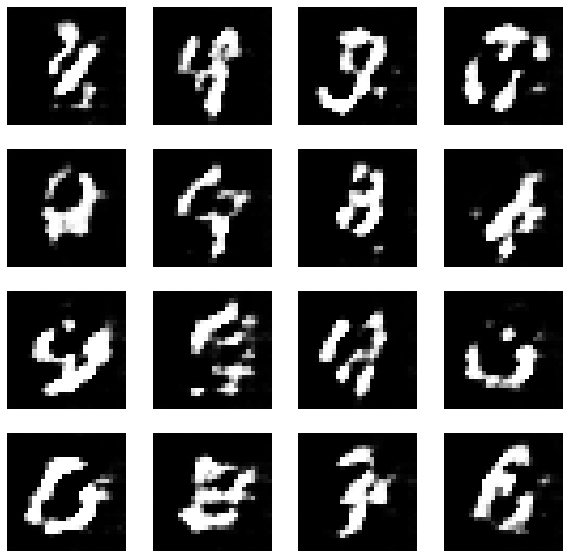

Epoch: 30


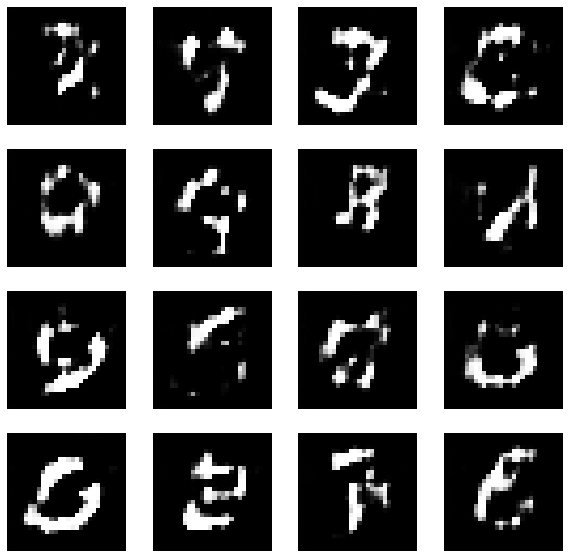

Epoch: 31


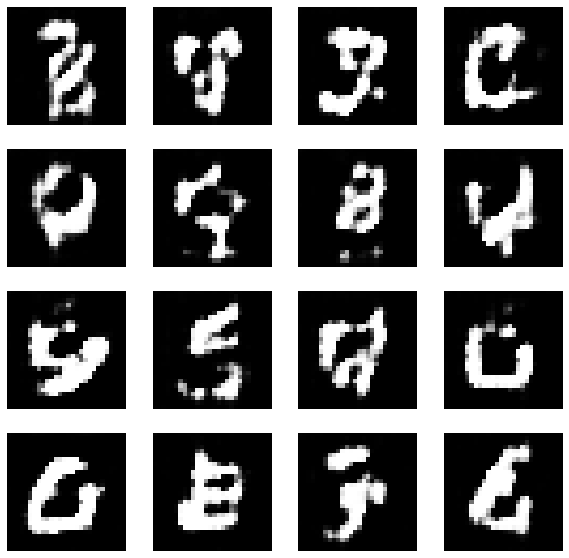

Epoch: 32


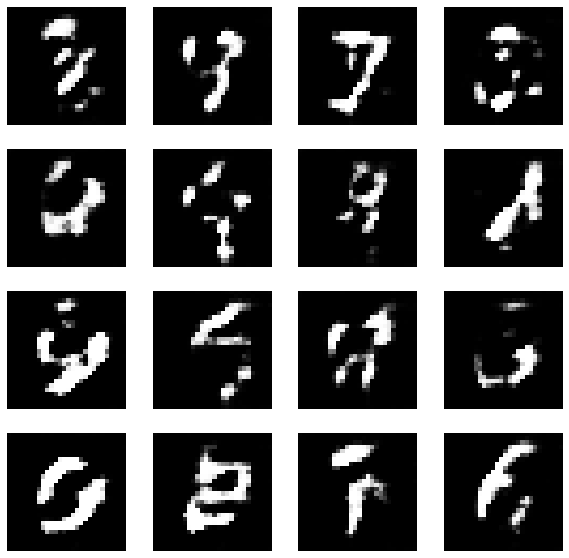

Epoch: 33


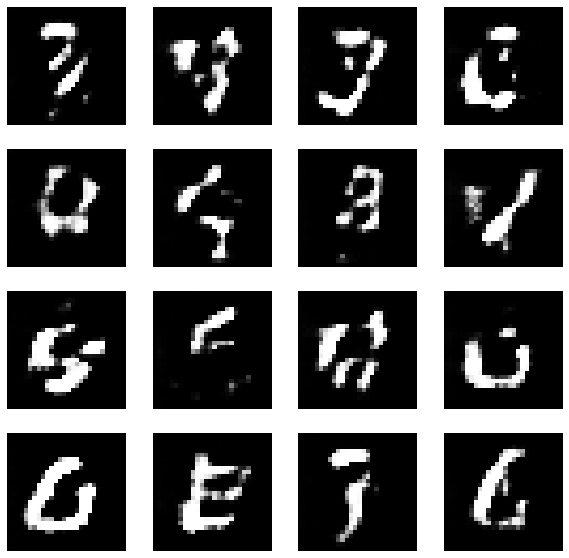

Epoch: 34


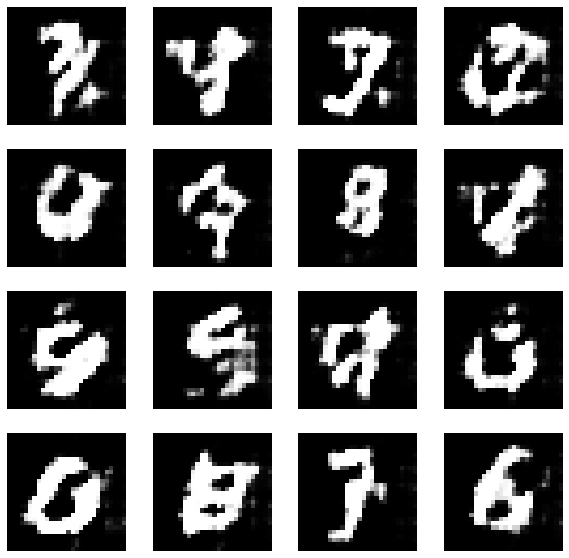

Epoch: 35


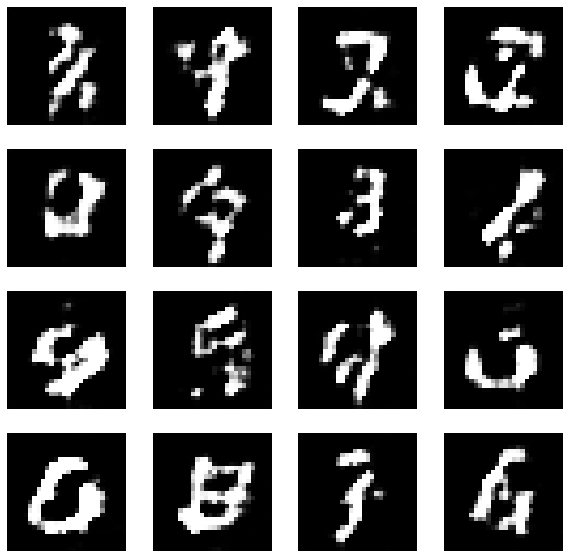

Epoch: 36


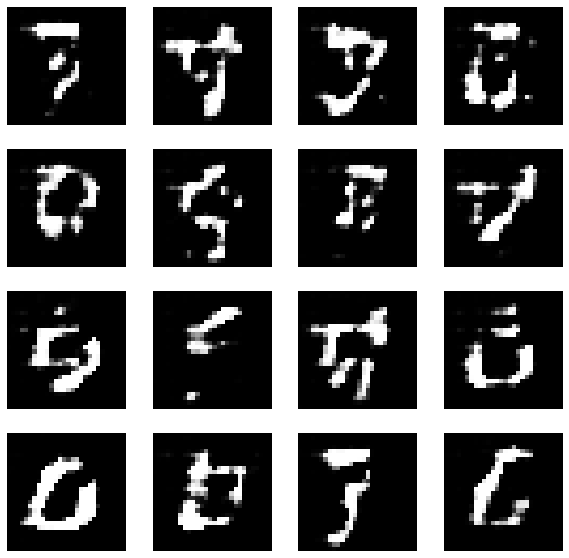

Epoch: 37


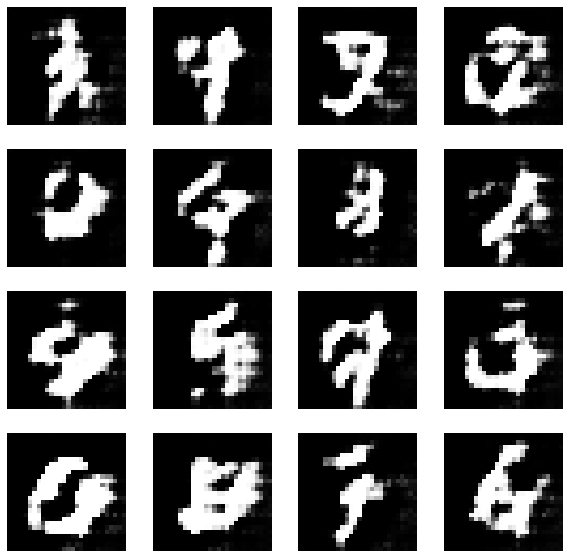

Epoch: 38


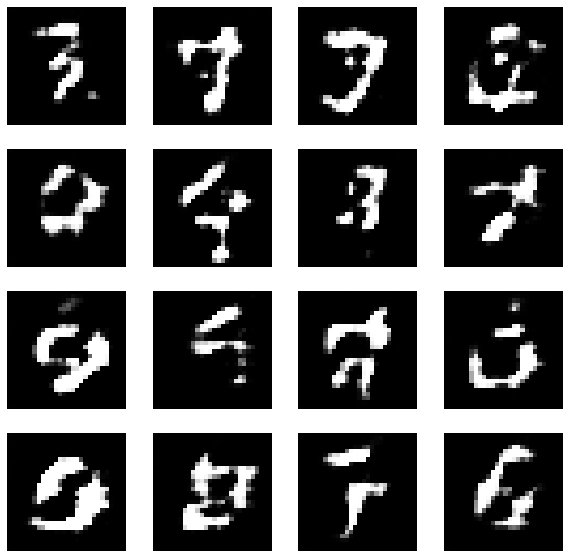

Epoch: 39


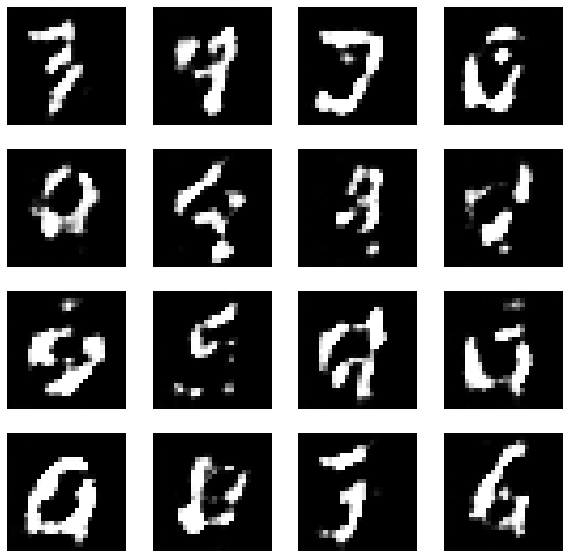

Epoch: 40


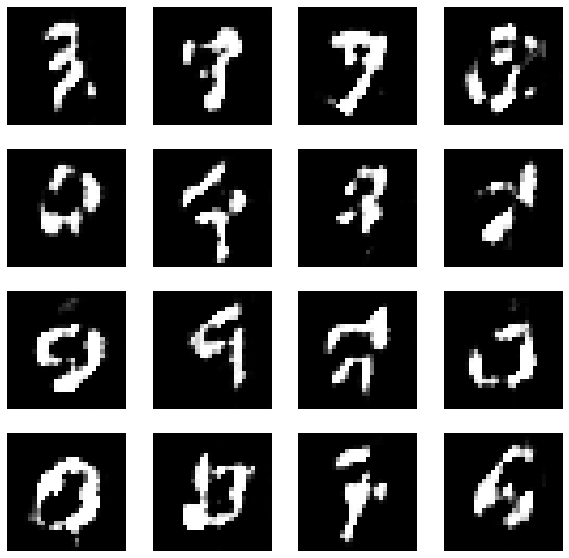

Epoch: 41


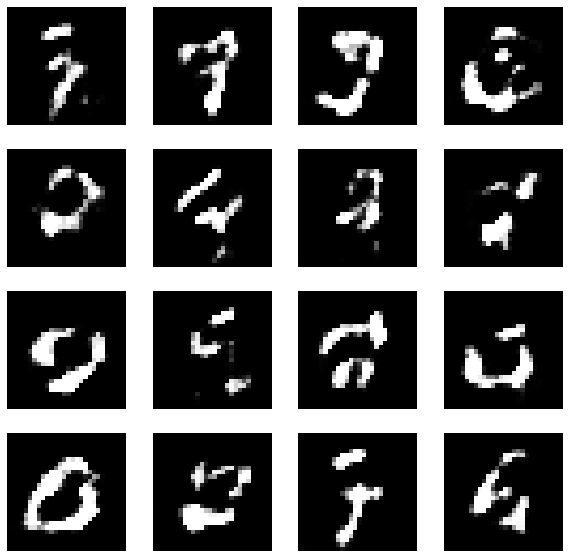

Epoch: 42


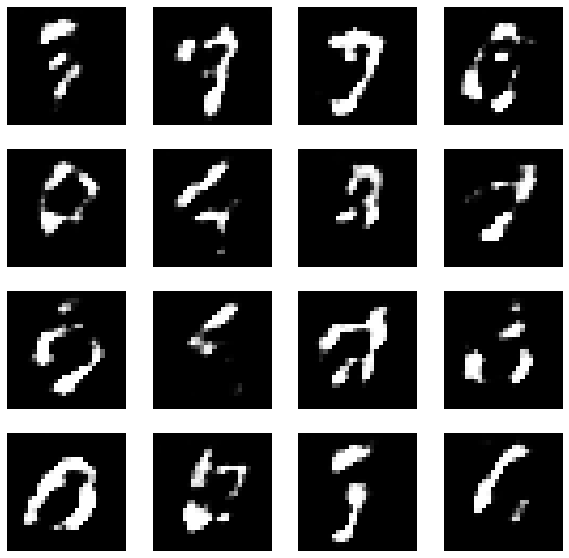

Epoch: 43


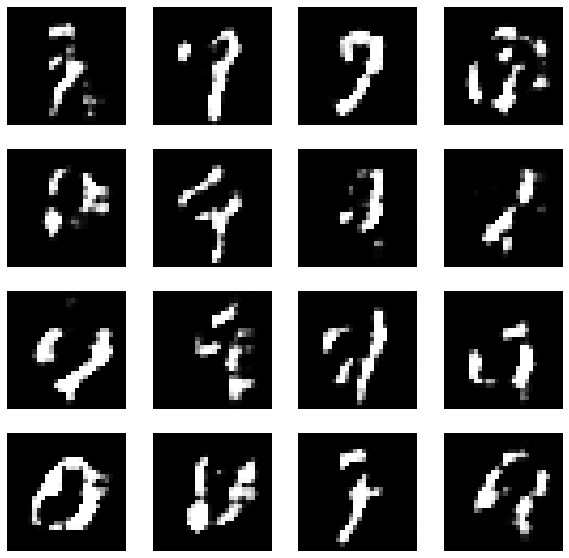

Epoch: 44


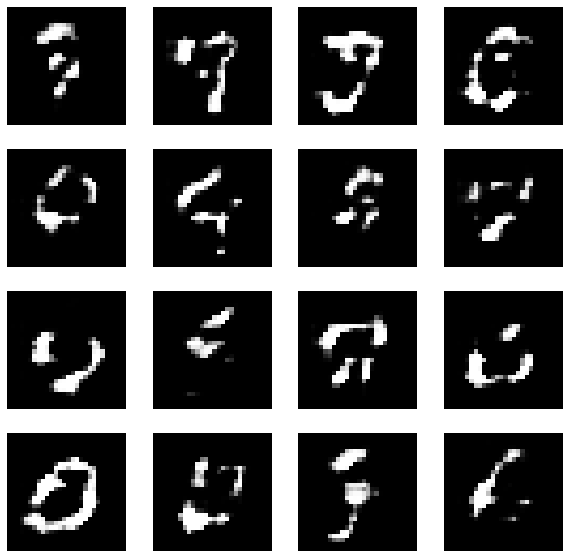

Epoch: 45


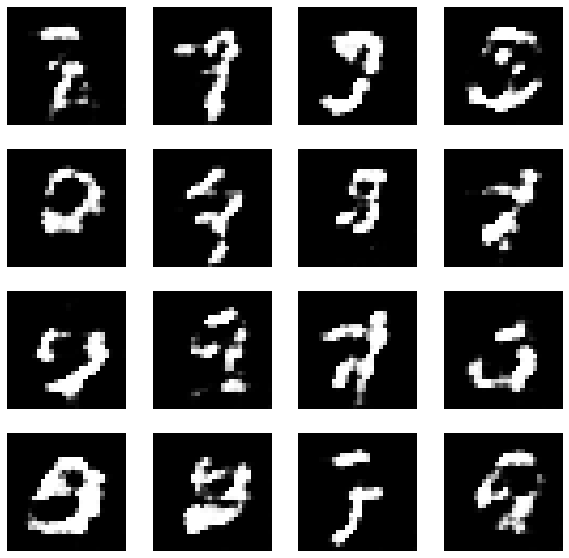

Epoch: 46


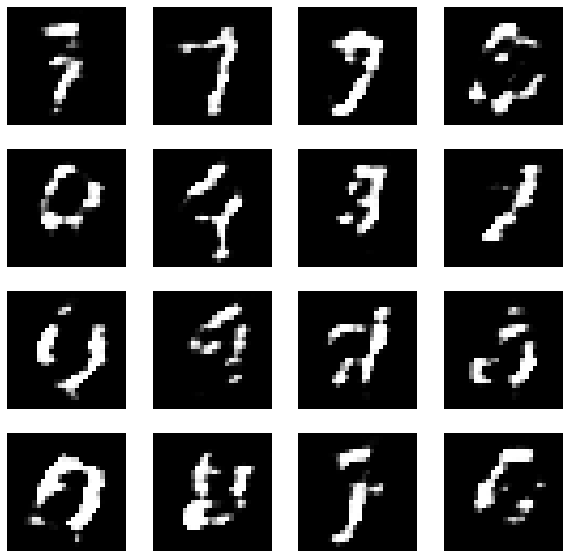

Epoch: 47


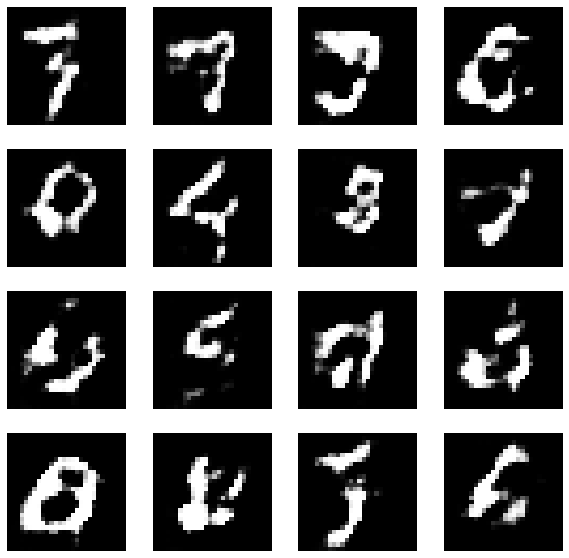

Epoch: 48


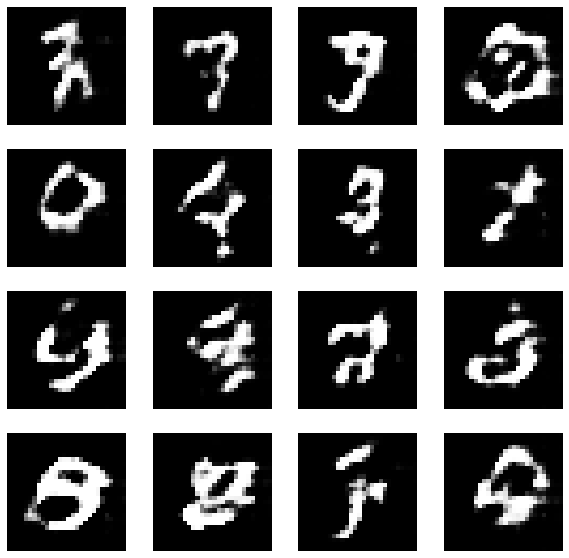

Epoch: 49


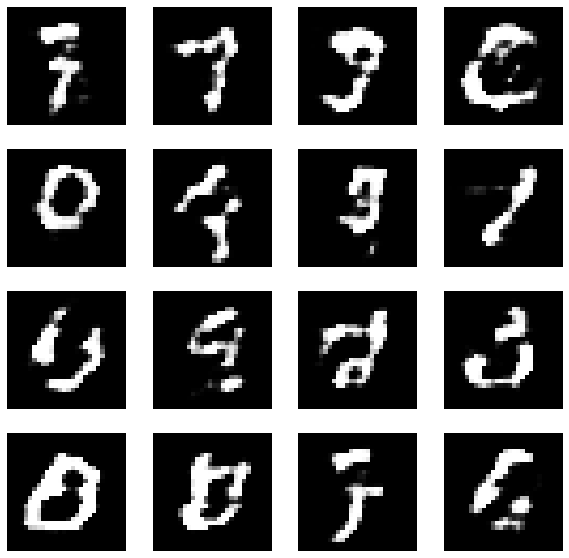

Epoch: 50


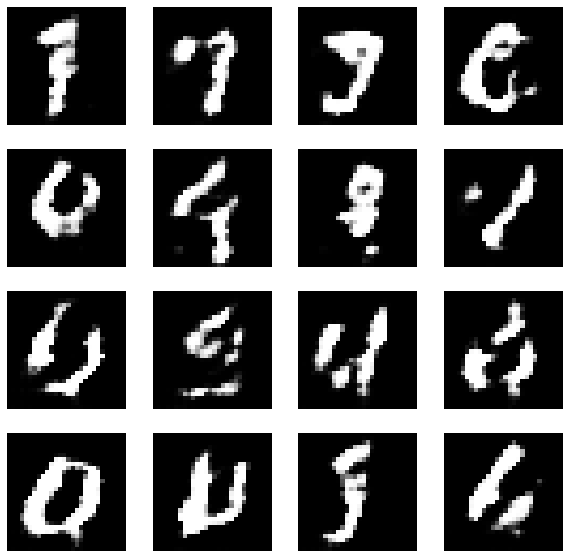

Epoch: 51


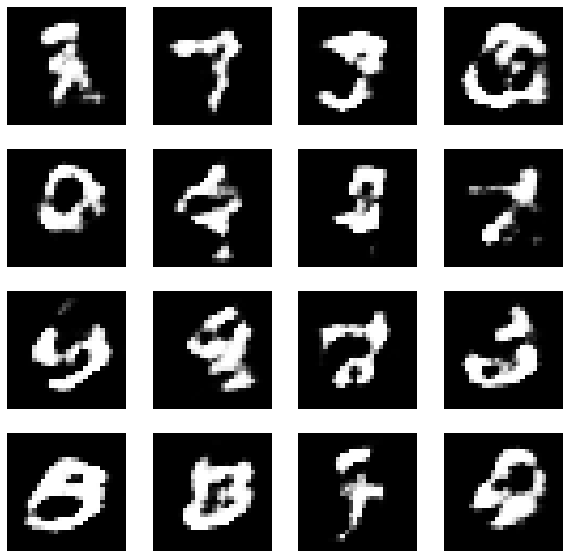

Epoch: 52


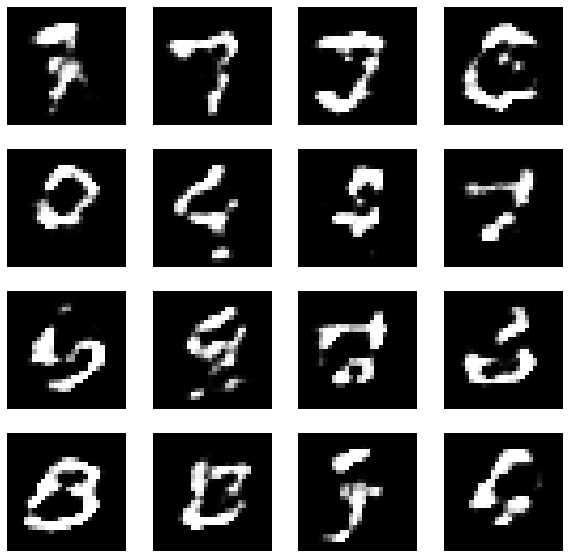

Epoch: 53


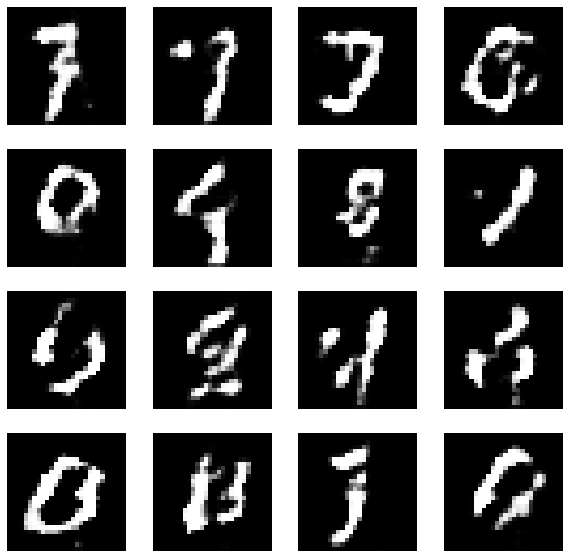

Epoch: 54


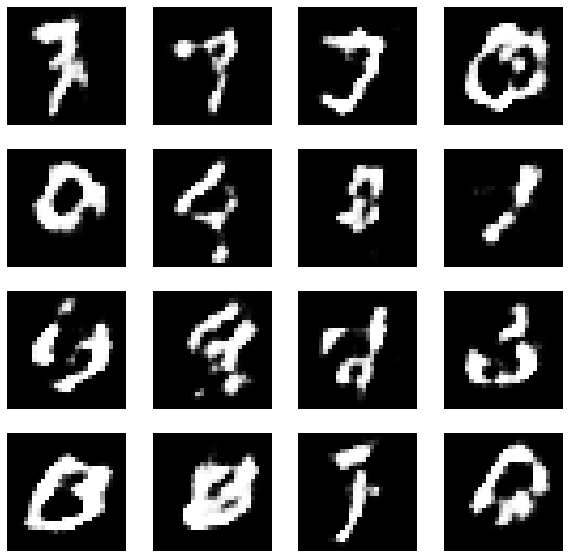

Epoch: 55


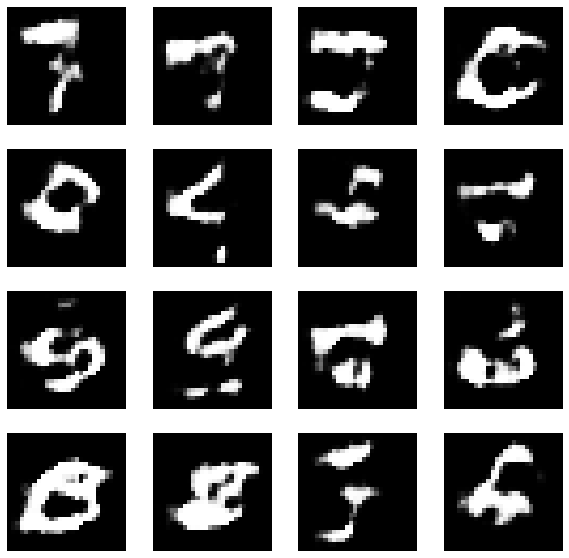

Epoch: 56


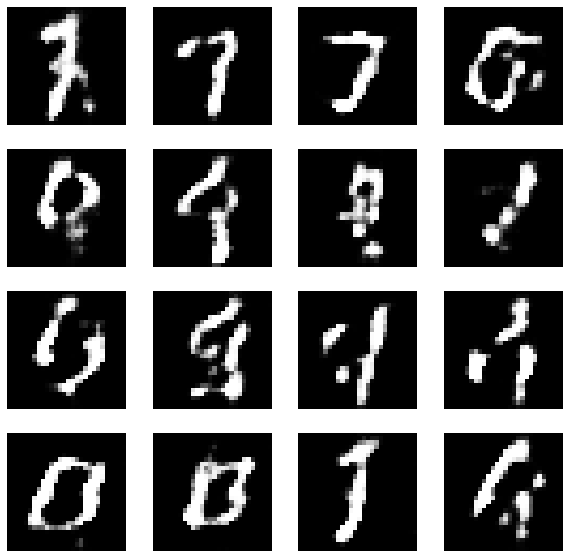

Epoch: 57


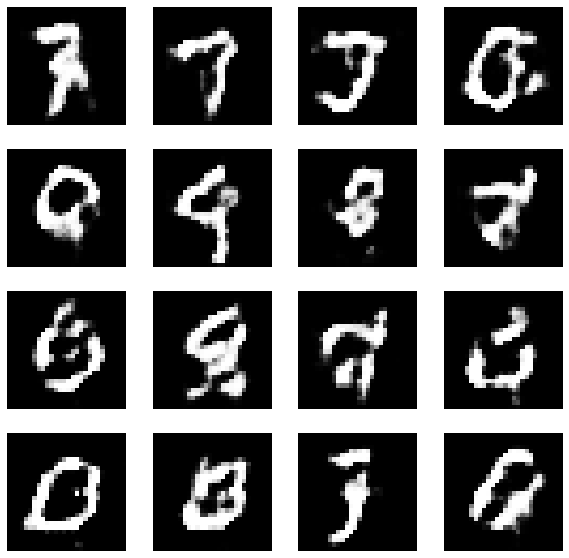

Epoch: 58


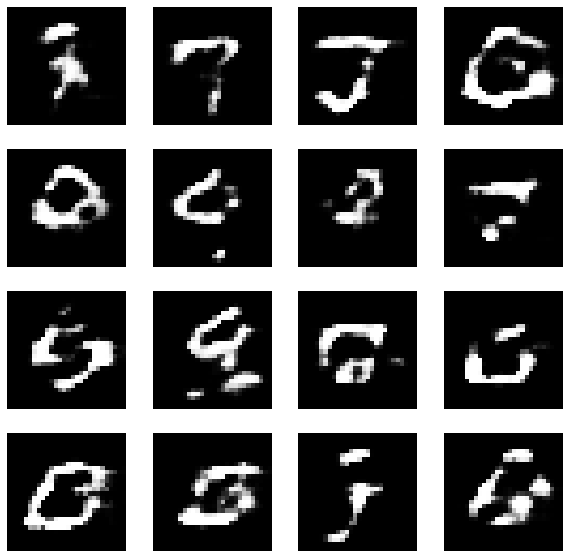

Epoch: 59


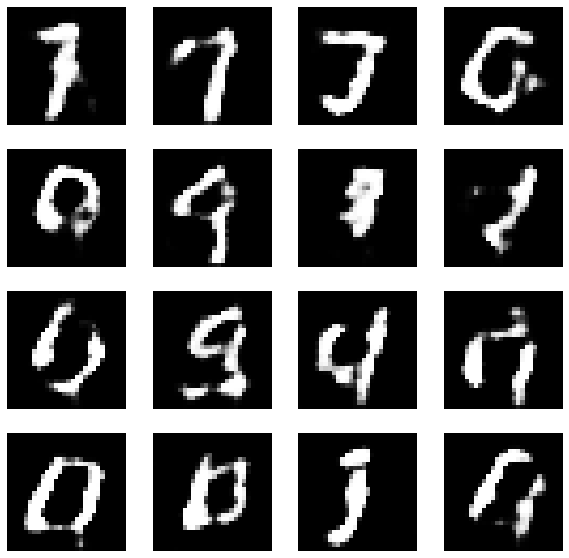

Epoch: 60


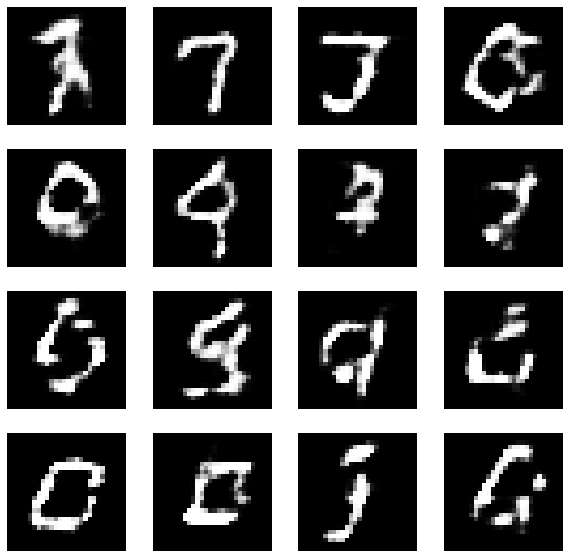

Epoch: 61


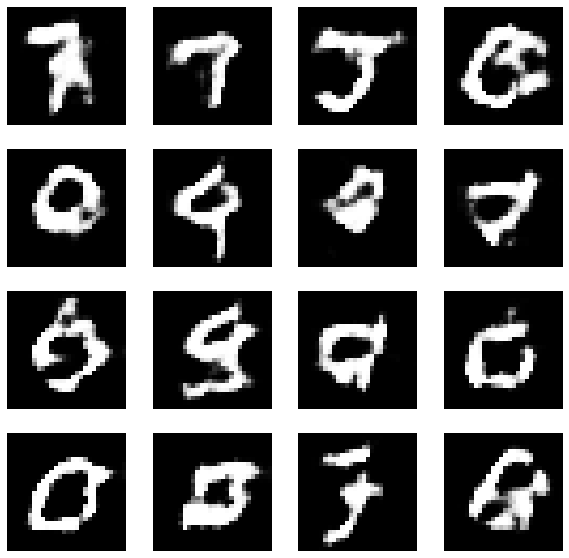

Epoch: 62


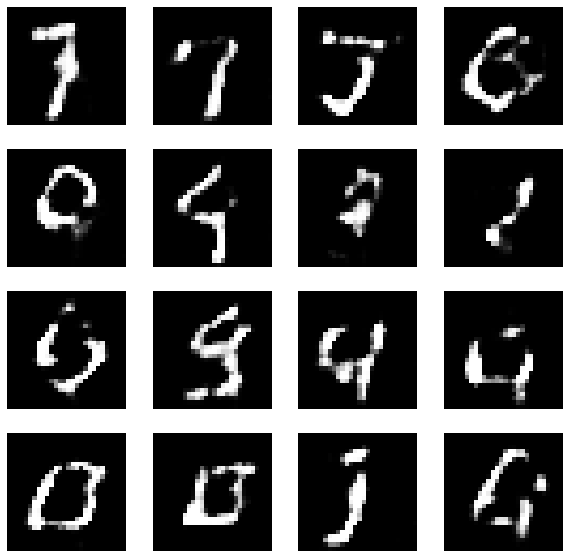

Epoch: 63


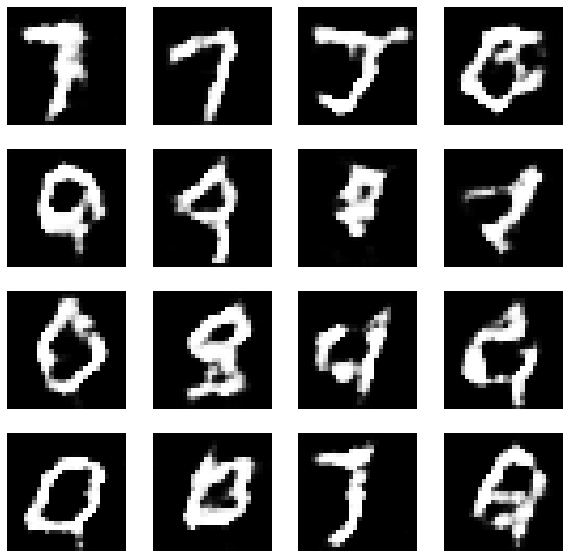

Epoch: 64


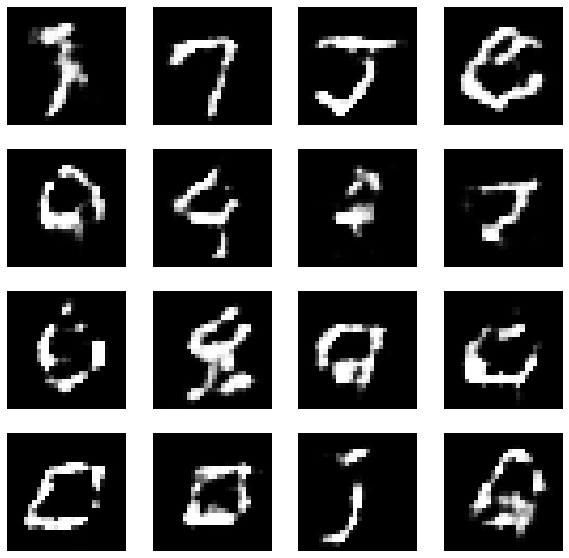

Epoch: 65


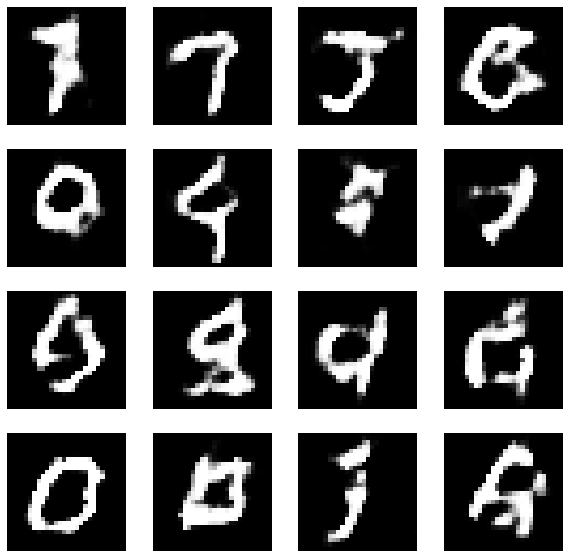

Epoch: 66


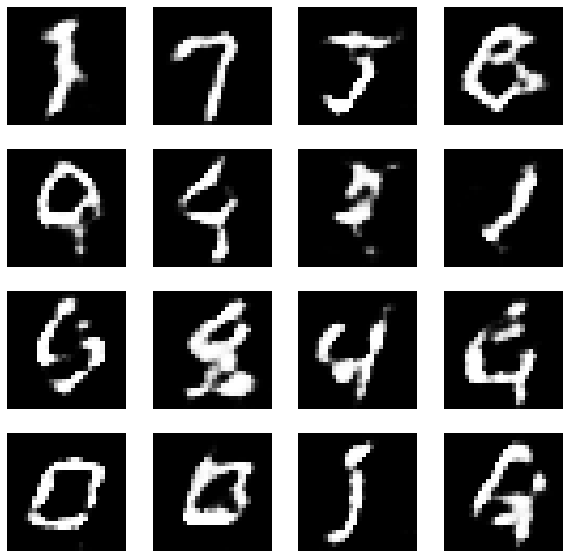

Epoch: 67


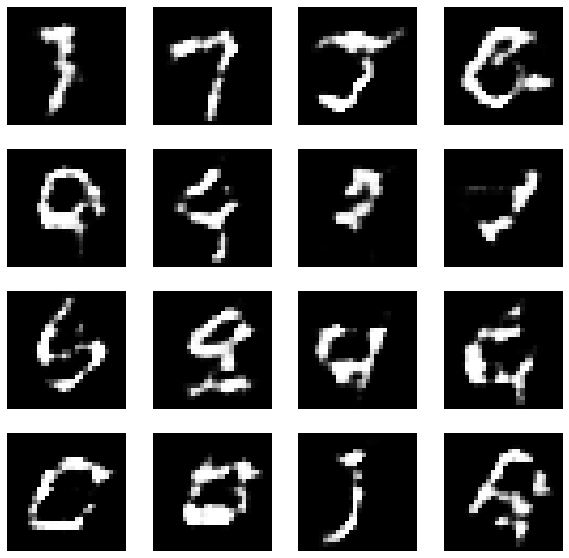

Epoch: 68


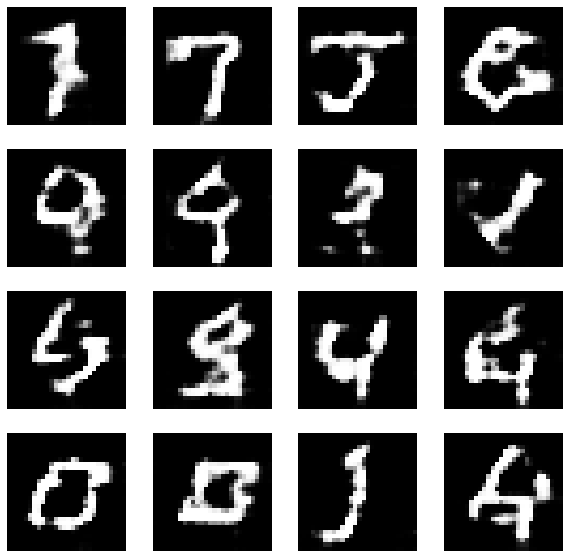

Epoch: 69


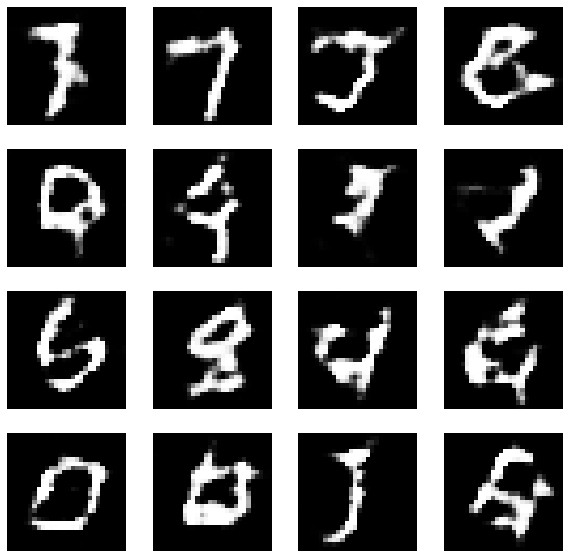

Epoch: 70


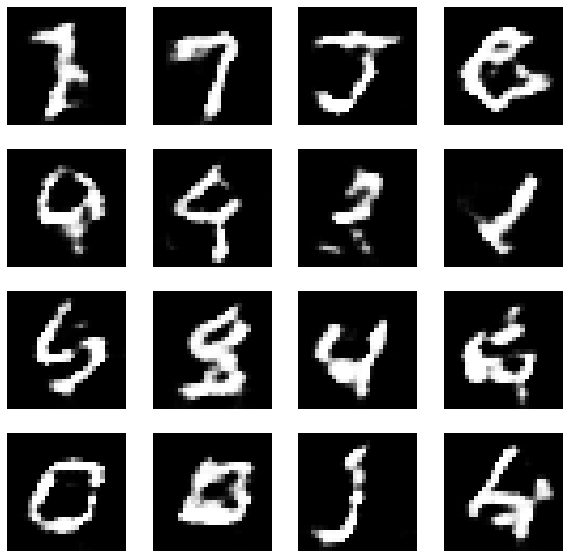

Epoch: 71


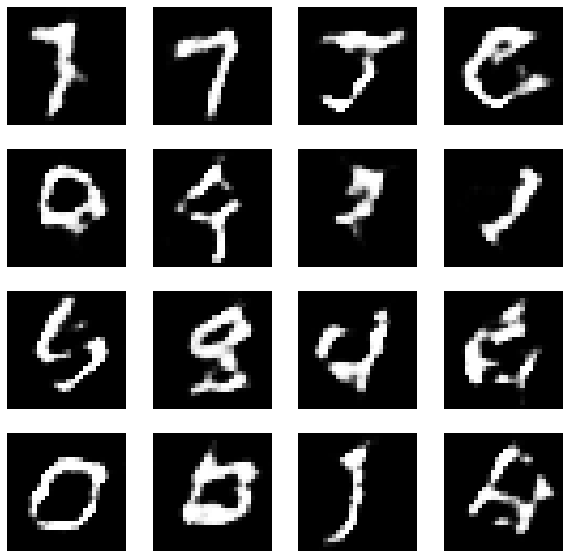

Epoch: 72


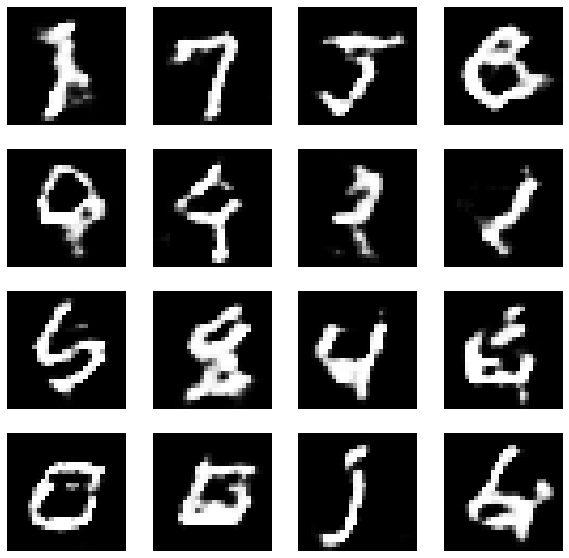

Epoch: 73


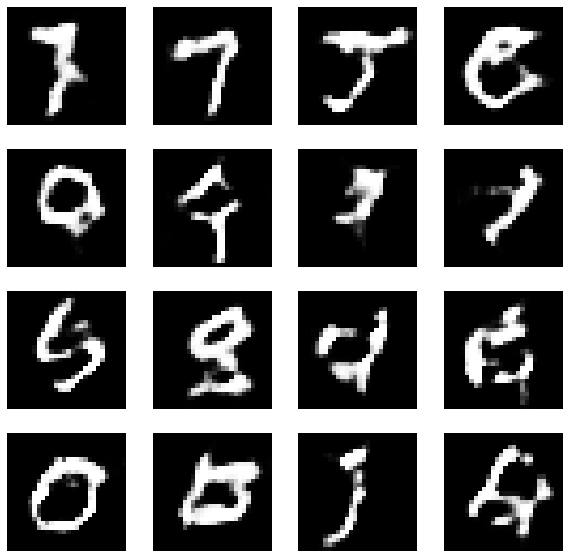

Epoch: 74


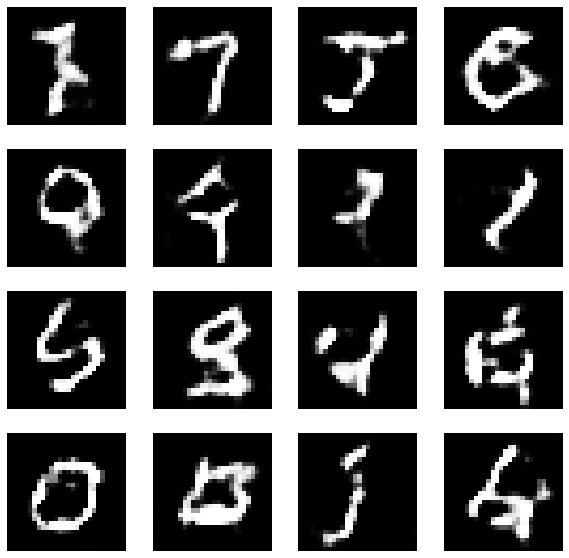

Epoch: 75


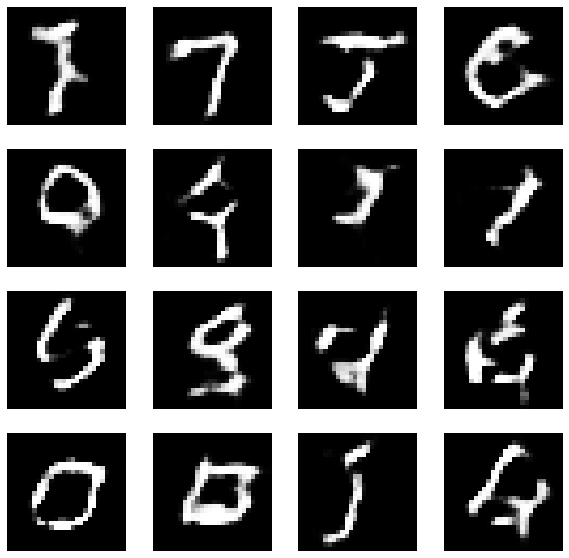

Epoch: 76


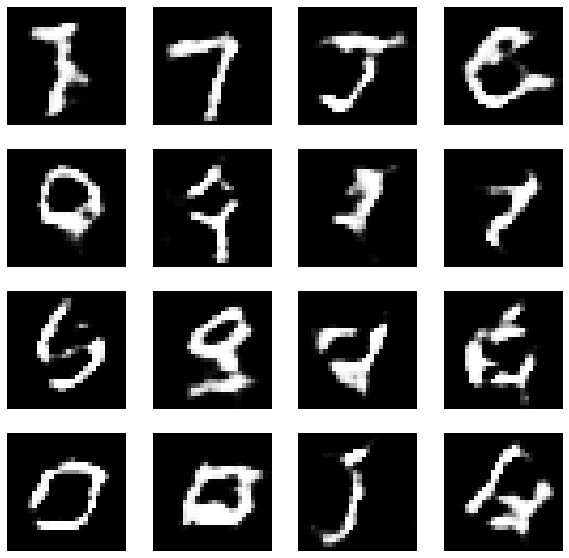

Epoch: 77


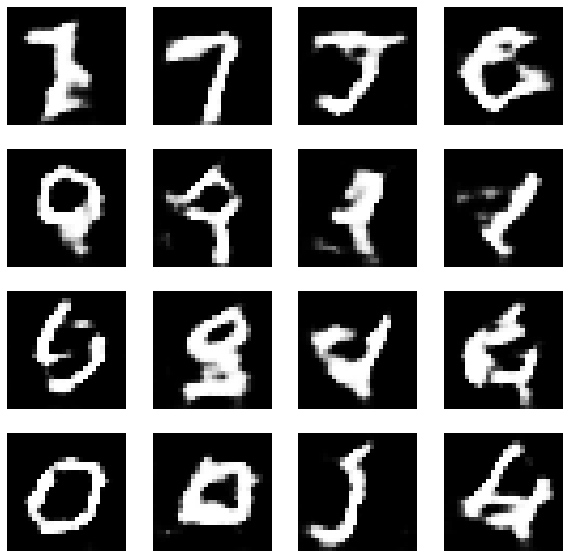

Epoch: 78


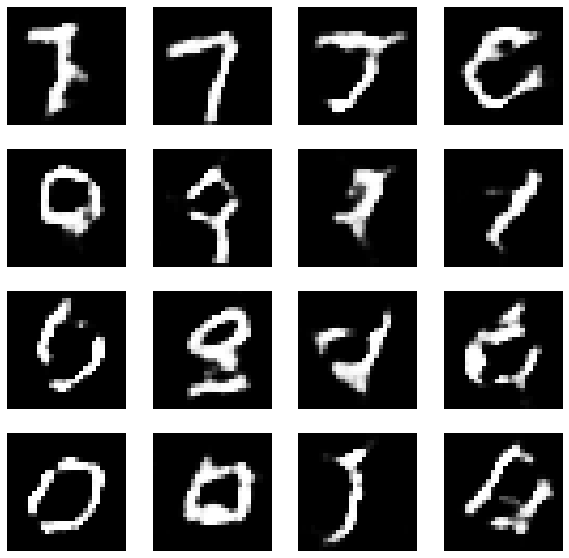

Epoch: 79


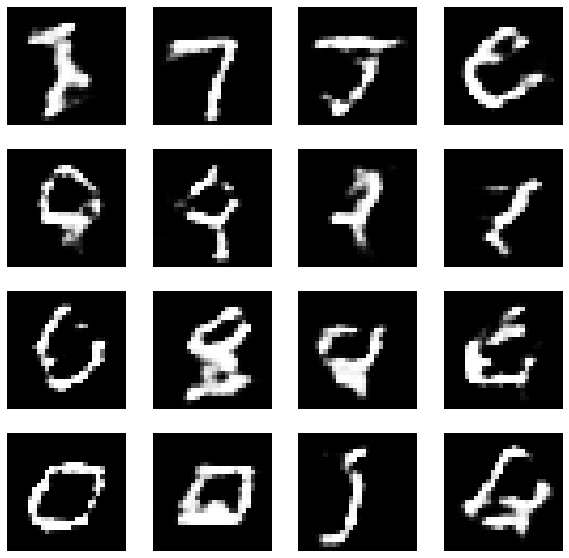

Epoch: 80


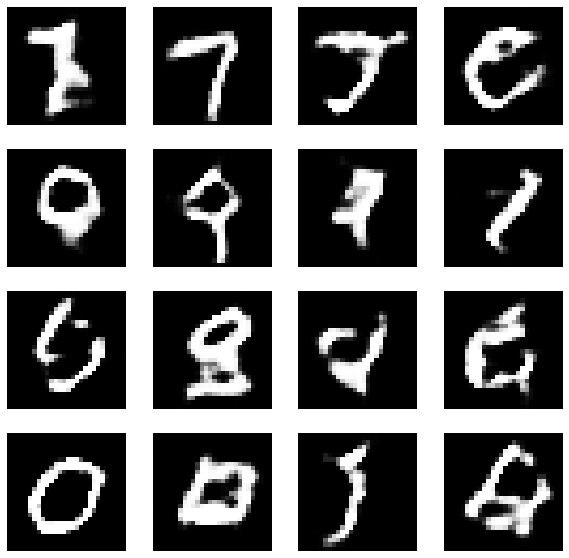

Epoch: 81


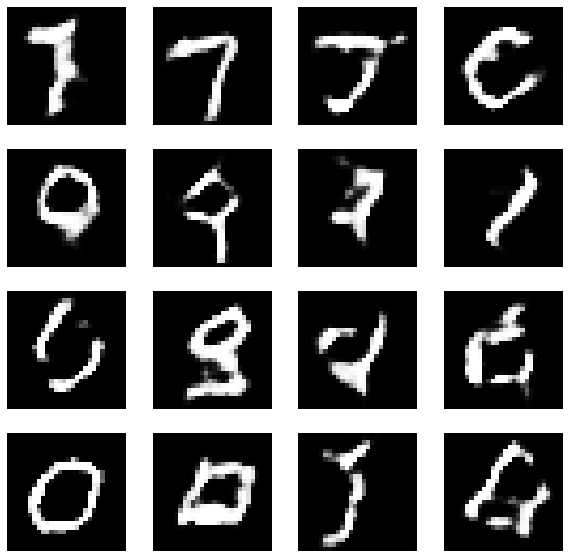

Epoch: 82


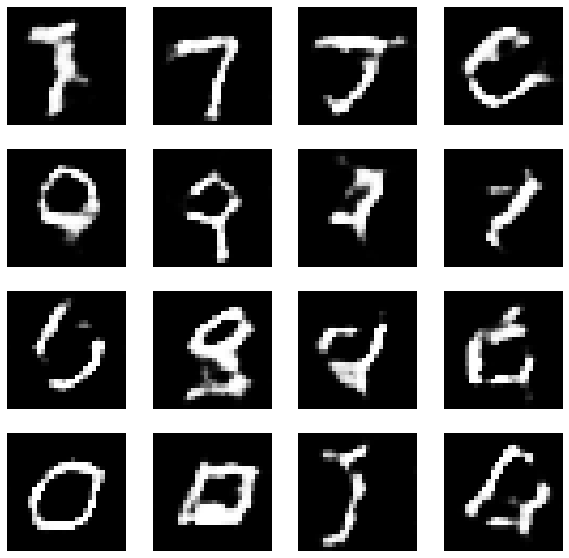

Epoch: 83


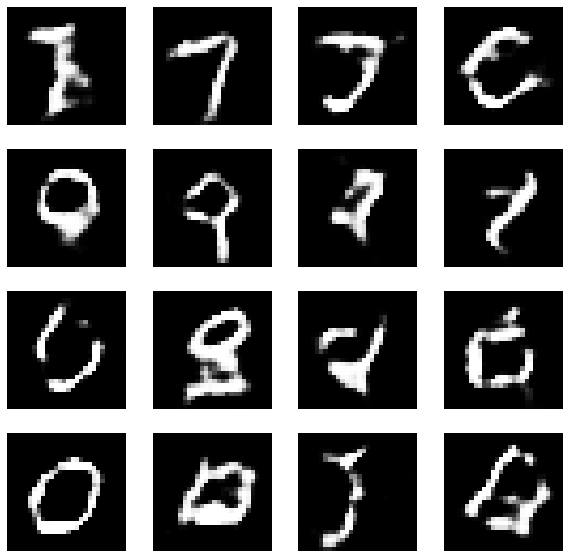

Epoch: 84


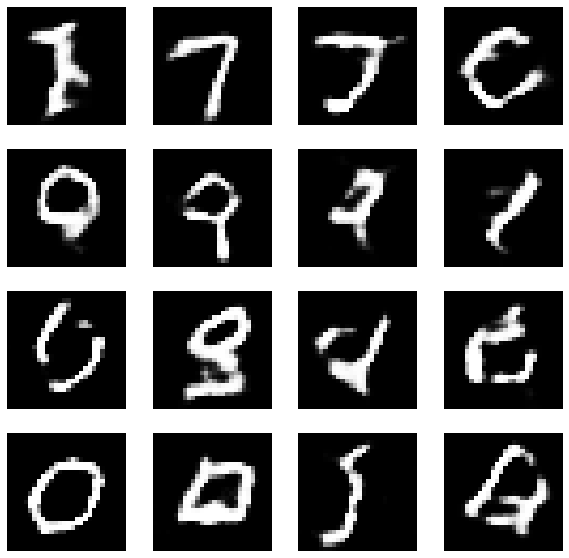

Epoch: 85


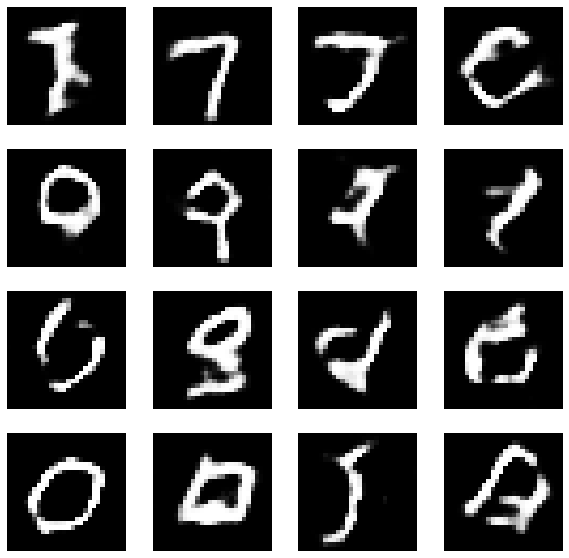

Epoch: 86


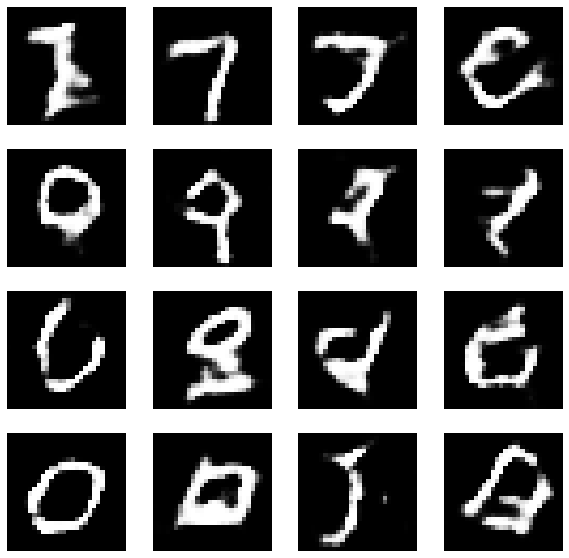

Epoch: 87


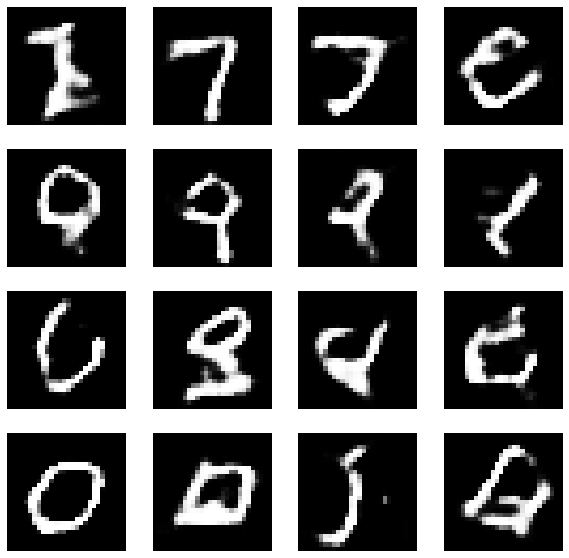

Epoch: 88


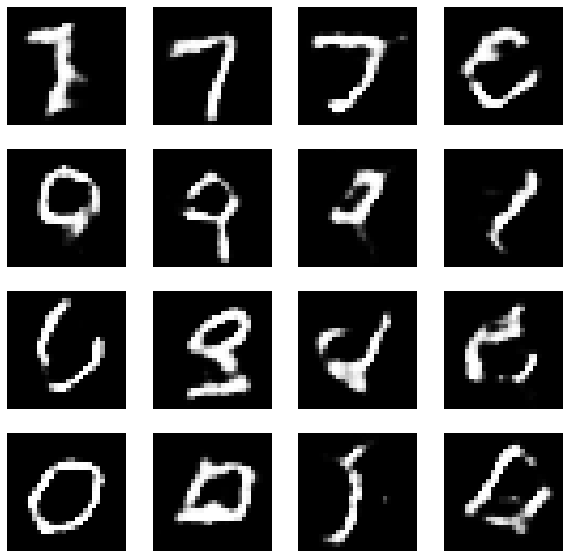

Epoch: 89


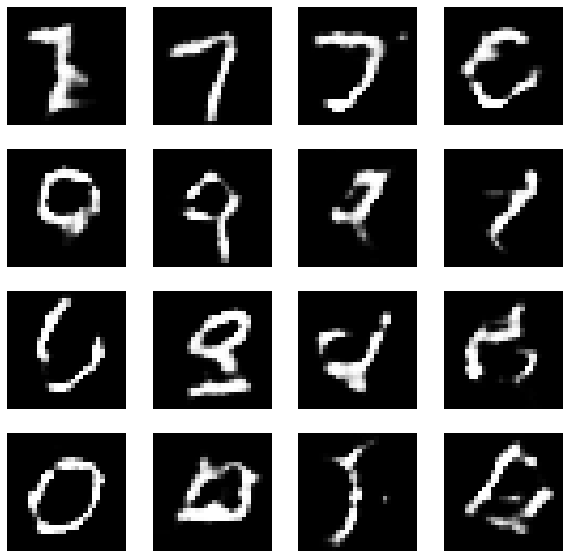

Epoch: 90


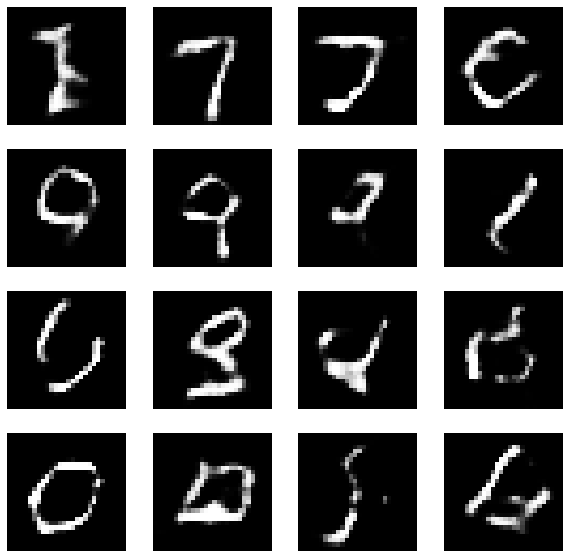

Epoch: 91


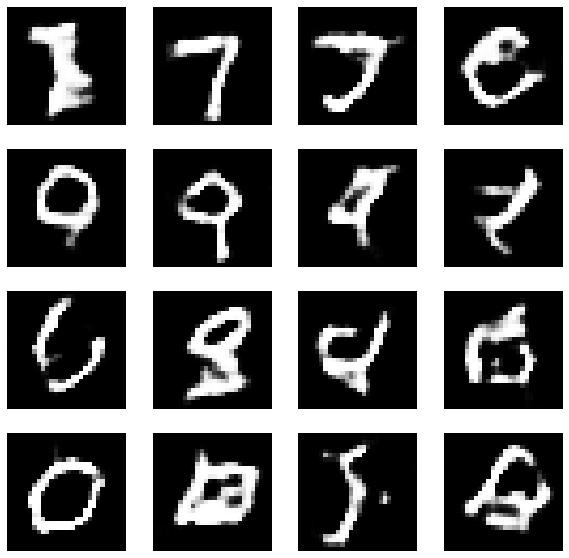

Epoch: 92


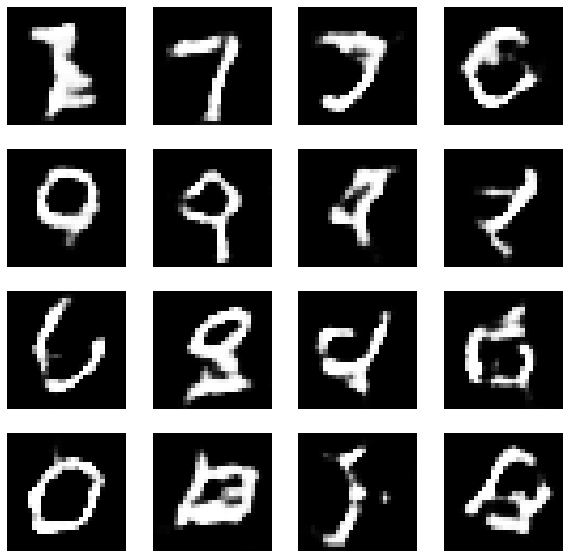

Epoch: 93


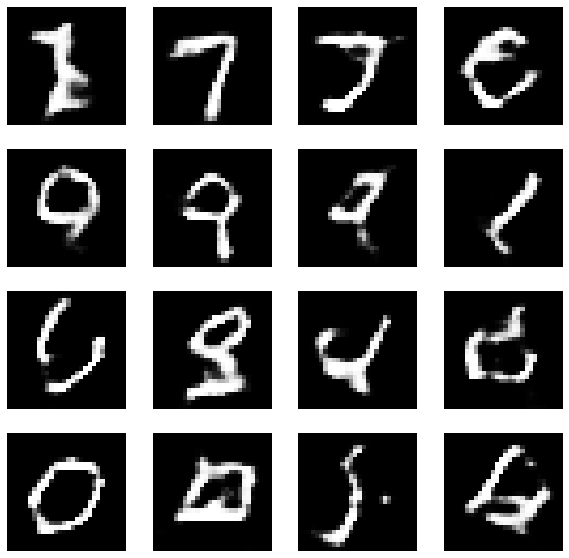

Epoch: 94


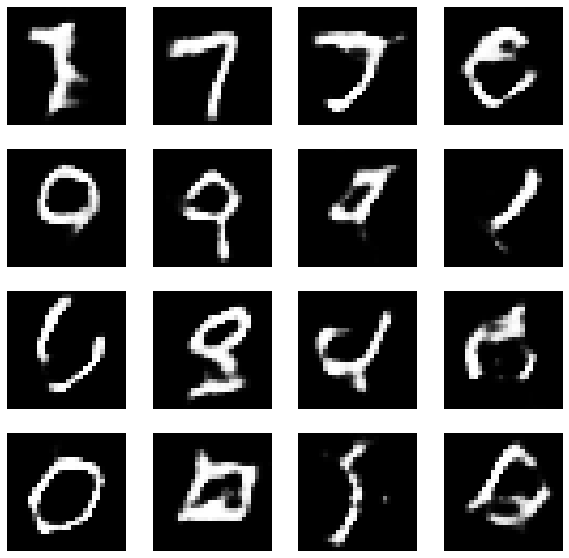

Epoch: 95


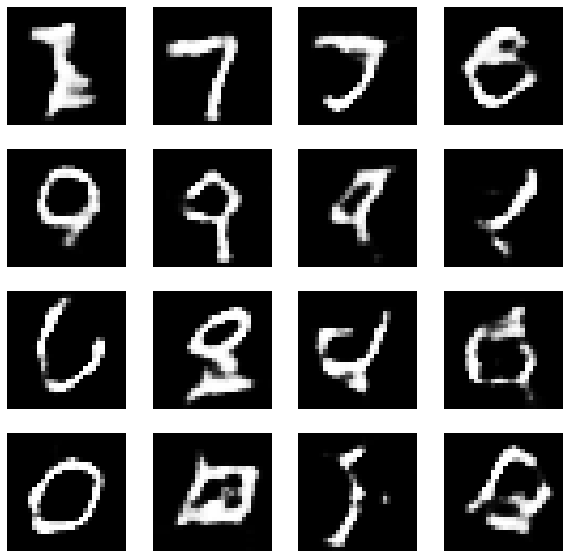

Epoch: 96


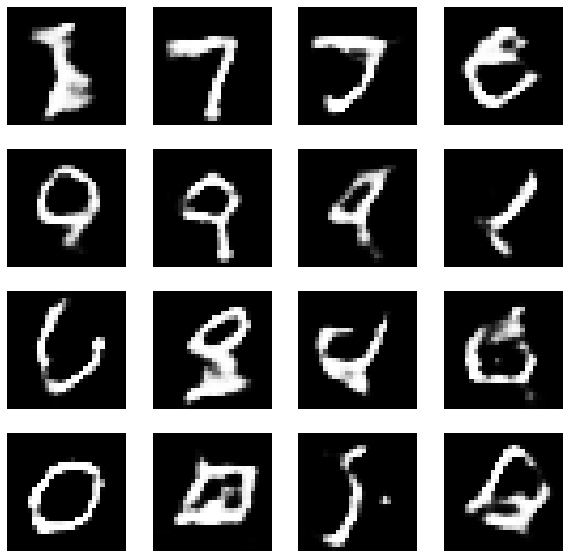

Epoch: 97


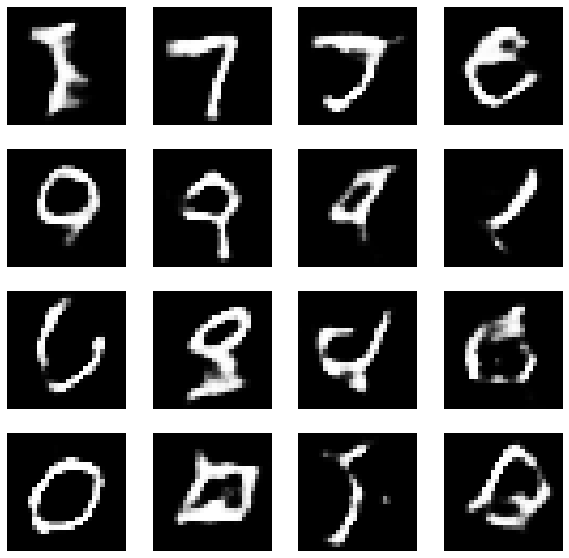

Epoch: 98


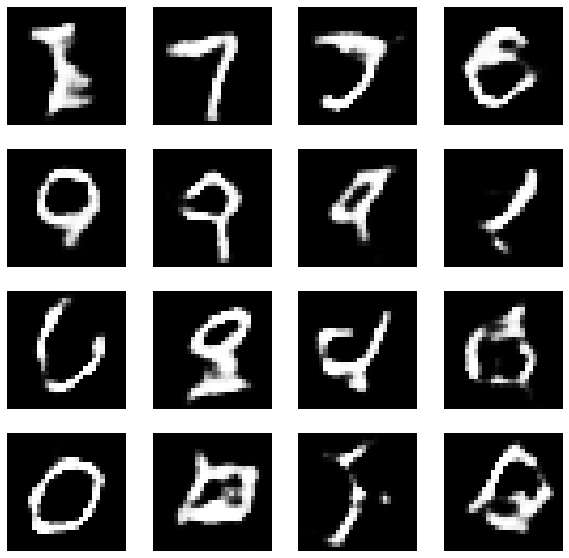

Epoch: 99


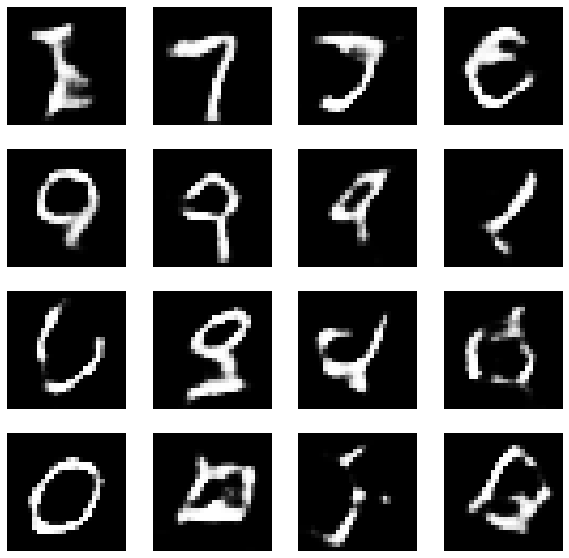

Epoch: 100


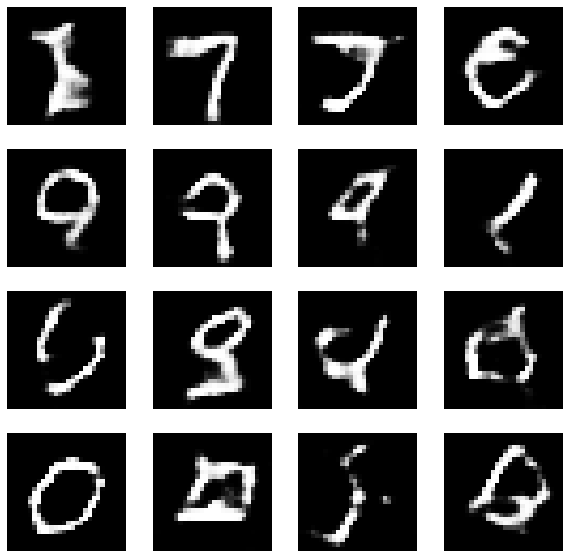

In [73]:
train(X_train, epochs, test_images)